<a href="https://colab.research.google.com/github/iliassBEN0408/project2_mit/blob/main/tp_mit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all necessary libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import requests
from io import BytesIO

# Transformers and Hugging Face
from transformers import ViTImageProcessor, ViTForImageClassification
from datasets import load_dataset

cudnn.benchmark = True
plt.ion()   # interactive mode


# I will use CIFAR-10 and extract class names. I will also load the pre-trained ViT model processor for image preprocessing

In [5]:
print("Loading CIFAR-10 dataset...")
from torchvision import datasets

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load datasets
basic_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load CIFAR-10 dataset
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=basic_transform)
val_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=basic_transform)

# Using subset for faster training, we can change these numbers later
train_subset_size = 5000  # Using only 5000 training samples instead of 50000
val_subset_size = 1000    # Using only 1000 validation samples instead of 10000

# Create subsets
train_indices = torch.randperm(len(train_dataset_full))[:train_subset_size]
val_indices = torch.randperm(len(val_dataset_full))[:val_subset_size]

train_dataset_raw = torch.utils.data.Subset(train_dataset_full, train_indices)
val_dataset_raw = torch.utils.data.Subset(val_dataset_full, val_indices)

print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset_raw)} (reduced from 50000)")
print(f"Validation samples: {len(val_dataset_raw)} (reduced from 10000)")


model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

Loading CIFAR-10 dataset...
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 5000 (reduced from 50000)
Validation samples: 1000 (reduced from 10000)


# Define data transformation functions and set up data loaders with custom collate function for ViT


In [6]:
class ViTDataset(torch.utils.data.Dataset):
    """Custom dataset wrapper for ViT preprocessing"""
    def __init__(self, dataset, processor, is_training=False):
        self.dataset = dataset
        self.processor = processor
        self.is_training = is_training

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # Convert tensor to PIL Image
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)

        # Apply data augmentation for training
        if self.is_training and np.random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        return {"img": image, "label": label}

# Create wrapped datasets
train_dataset = ViTDataset(train_dataset_raw, processor, is_training=True)
val_dataset = ViTDataset(val_dataset_raw, processor, is_training=False)


def collate_fn(batch):
    # Extract images and labels from batch
    images = [item["img"].convert("RGB") for item in batch]
    labels = [item["label"] for item in batch]

    # Process with ViT processor
    encoding = processor(images, return_tensors="pt")
    encoding["labels"] = torch.tensor(labels)
    return encoding

dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Set up computation device and define visualization functions


In [7]:

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Denormalize for ViT
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Using cuda device


# Display sample images from the training dataset



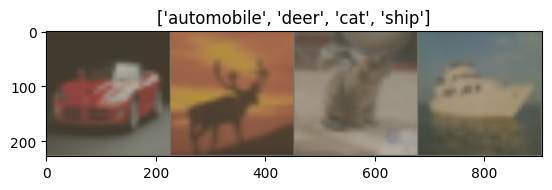

In [8]:
inputs = next(iter(dataloaders['train']))
sample_images = inputs['pixel_values']
sample_labels = inputs['labels']

# Make a grid from batch
out = torchvision.utils.make_grid(sample_images[:4])
imshow(out, title=[class_names[x] for x in sample_labels[:4]])


# Training function for both fine tuning and feature extraction approaches


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for batch in dataloaders[phase]:
                    pixel_values = batch['pixel_values'].to(device)
                    labels = batch['labels'].to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(pixel_values=pixel_values, labels=labels)
                        loss = outputs.loss
                        _, preds = torch.max(outputs.logits, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * pixel_values.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


# Function to visualize model predictions on validation data


In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for batch in dataloaders['val']:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values)
            _, preds = torch.max(outputs.logits, 1)

            for j in range(pixel_values.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(pixel_values.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# Initialize ViT model for fine-tuning (all parameters) and train it


In [11]:
model_ft = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label={str(i): class_names[i] for i in range(len(class_names))},
    label2id={class_names[i]: i for i in range(len(class_names))},
    ignore_mismatched_sizes=True
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train the ViT model with all parameters being updated
print("Training fine-tuning model...")
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)



config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fine-tuning model...
Epoch 0/4
----------
train Loss: 0.2478 Acc: 0.9354
val Loss: 0.0808 Acc: 0.9750

Epoch 1/4
----------
train Loss: 0.0318 Acc: 0.9920
val Loss: 0.0605 Acc: 0.9760

Epoch 2/4
----------
train Loss: 0.0108 Acc: 0.9990
val Loss: 0.0663 Acc: 0.9760

Epoch 3/4
----------
train Loss: 0.0057 Acc: 0.9998
val Loss: 0.0678 Acc: 0.9790

Epoch 4/4
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.0629 Acc: 0.9780

Training complete in 15m 23s
Best val Acc: 0.979000


# Display predictions from the fine-tuned model


Fine-tuning results:


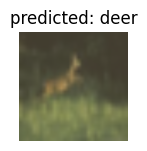

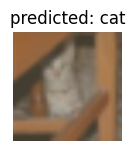

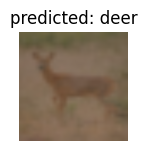

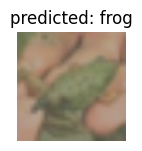

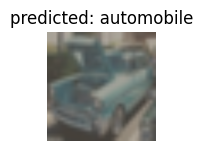

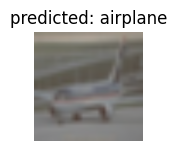

In [12]:
print("Fine-tuning results:")
visualize_model(model_ft)

# Initialize ViT model for feature extraction (freeze backbone)


In [13]:
model_conv = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label={str(i): class_names[i] for i in range(len(class_names))},
    label2id={class_names[i]: i for i in range(len(class_names))},
    ignore_mismatched_sizes=True
)

# Freeze all ViT parameters except classifier
for param in model_conv.vit.parameters():
    param.requires_grad = False

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train the ViT model with frozen backbone (only classifier updated)
print("Training feature extraction model...")
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training feature extraction model...
Epoch 0/4
----------
train Loss: 0.3486 Acc: 0.9148
val Loss: 0.1743 Acc: 0.9530

Epoch 1/4
----------
train Loss: 0.1304 Acc: 0.9658
val Loss: 0.1517 Acc: 0.9530

Epoch 2/4
----------
train Loss: 0.1072 Acc: 0.9702
val Loss: 0.1390 Acc: 0.9540

Epoch 3/4
----------
train Loss: 0.0927 Acc: 0.9754
val Loss: 0.1374 Acc: 0.9510

Epoch 4/4
----------
train Loss: 0.0824 Acc: 0.9784
val Loss: 0.1303 Acc: 0.9530

Training complete in 6m 37s
Best val Acc: 0.954000


# Display predictions from the feature extraction model


Feature extraction results:


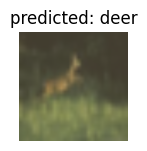

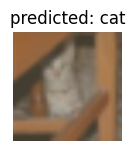

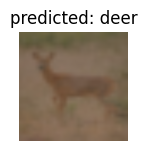

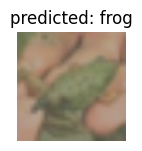

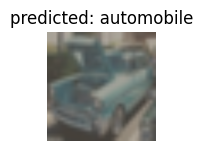

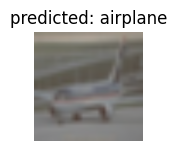

In [14]:
print("Feature extraction results:")
visualize_model(model_conv)


# Function to test model on external images



In [15]:
def test_external_image(image_url, model, title="External Image Test"):
    """Test model on an external image from URL"""
    try:
        # Download image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Preprocess image
        inputs = processor(img, return_tensors="pt").to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class_idx = probabilities.argmax().item()
            confidence = probabilities[0][predicted_class_idx].item()

        # Display result
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"{title}\nPredicted: {class_names[predicted_class_idx]} (Confidence: {confidence:.3f})")
        plt.axis('off')
        plt.show()

        return class_names[predicted_class_idx], confidence

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, 0

# Test the trained models with various images from Unsplash





Testing fine-tuned model on external images:


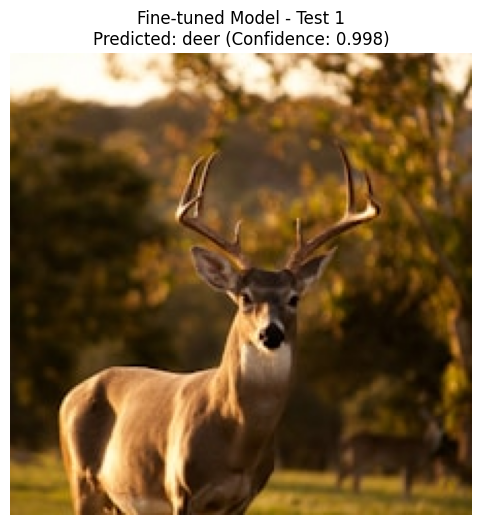

Test 1: Predicted deer with 0.998 confidence


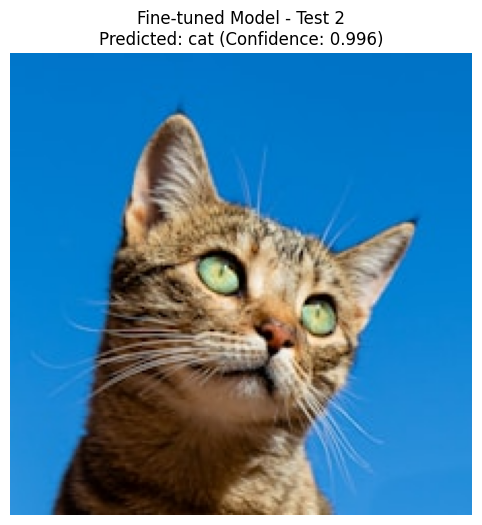

Test 2: Predicted cat with 0.996 confidence


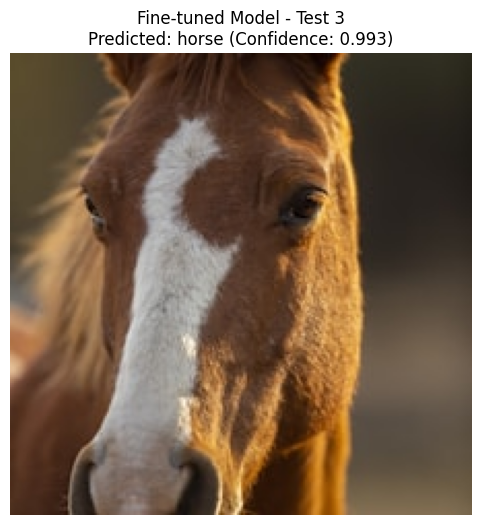

Test 3: Predicted horse with 0.993 confidence


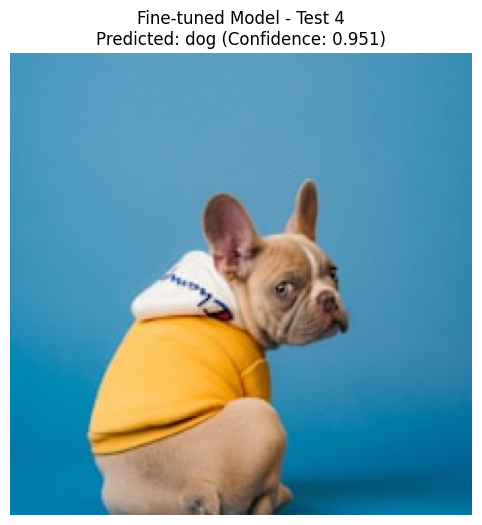

Test 4: Predicted dog with 0.951 confidence


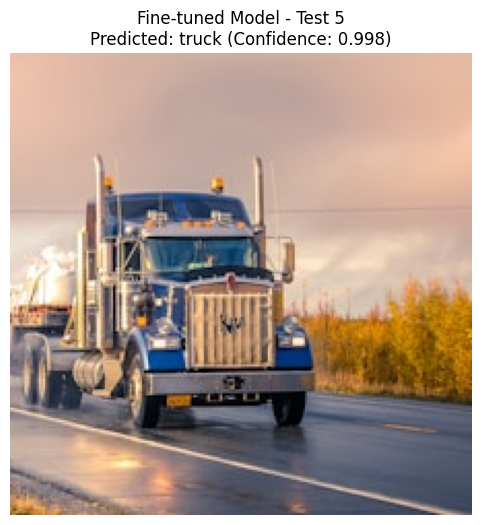

Test 5: Predicted truck with 0.998 confidence

Testing feature extraction model on external images:


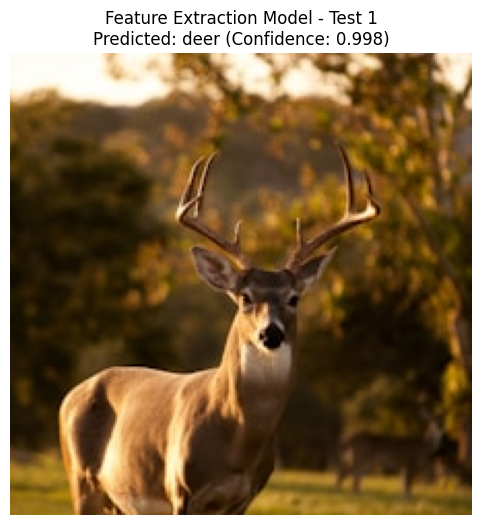

Test 1: Predicted deer with 0.998 confidence


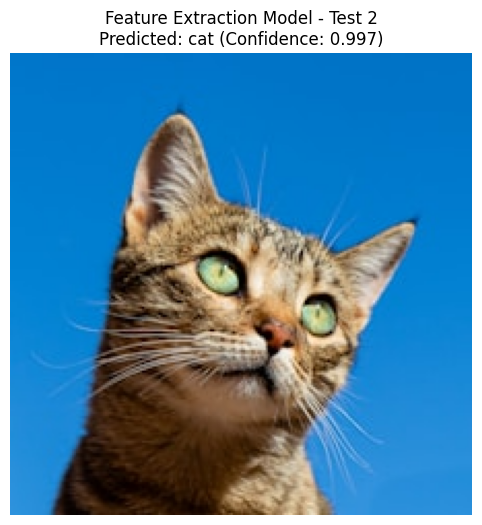

Test 2: Predicted cat with 0.997 confidence


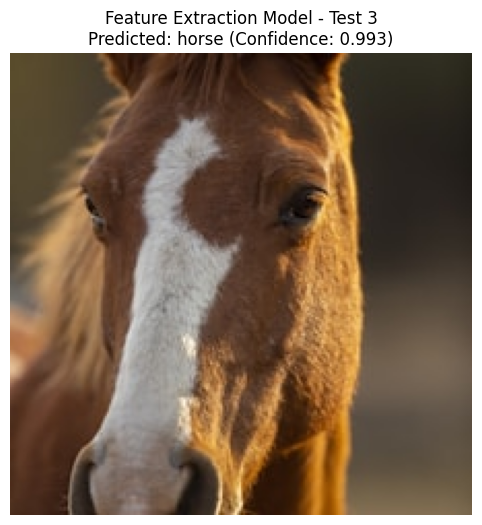

Test 3: Predicted horse with 0.993 confidence


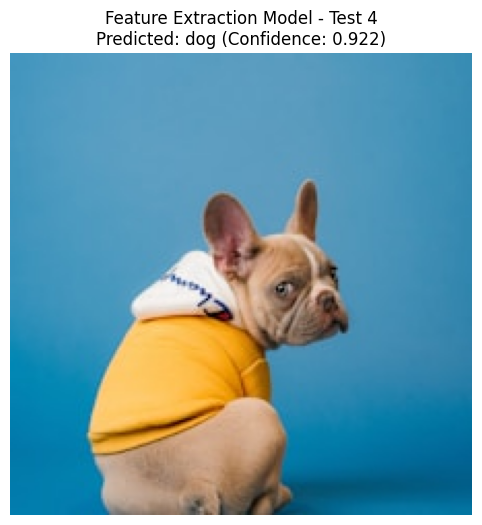

Test 4: Predicted dog with 0.922 confidence


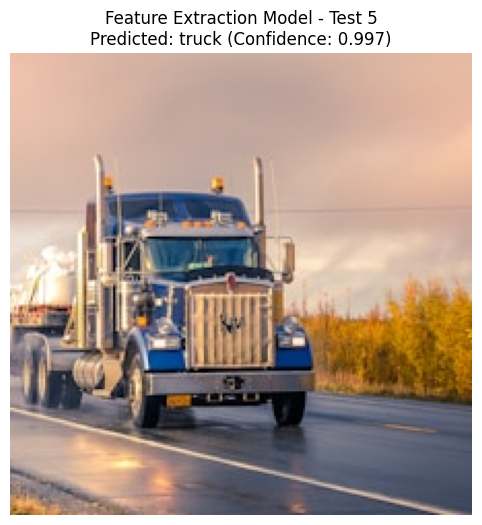

Test 5: Predicted truck with 0.997 confidence
Testing with validation sample:
True label: deer
Error: 'Image' object has no attribute 'startswith'


In [16]:
test_images = [
    "https://images.unsplash.com/photo-1484406566174-9da000fda645?w=224&h=224&fit=crop&crop=center",  # Deer
    "https://images.unsplash.com/photo-1574158622682-e40e69881006?w=224&h=224&fit=crop&crop=center",  # Cat
    "https://images.unsplash.com/photo-1598974357801-cbca100e65d3?w=224&h=224&fit=crop&crop=center", # Horse
    "https://images.unsplash.com/photo-1583337130417-3346a1be7dee?w=224&h=224&fit=crop&crop=center",  # Dog
    "https://images.unsplash.com/photo-1591768793355-74d04bb6608f?w=224&h=224&fit=crop&crop=center"  # Truck
]

print("Testing fine-tuned model on external images:")
for i, img_url in enumerate(test_images):
    prediction, confidence = test_external_image(img_url, model_ft, f"Fine-tuned Model - Test {i+1}")
    if prediction:
        print(f"Test {i+1}: Predicted {prediction} with {confidence:.3f} confidence")

print("\nTesting feature extraction model on external images:")
for i, img_url in enumerate(test_images):
    prediction, confidence = test_external_image(img_url, model_conv, f"Feature Extraction Model - Test {i+1}")
    if prediction:
        print(f"Test {i+1}: Predicted {prediction} with {confidence:.3f} confidence")

# Utility function for making predictions on single images
def predict_single_image(model, image_path_or_url, show_image=True):
    """Make prediction on a single image"""
    try:
        # Load image
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url)
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_path_or_url).convert("RGB")

        # Preprocess and predict
        inputs = processor(img, return_tensors="pt").to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class_idx = probabilities.argmax().item()
            confidence = probabilities[0][predicted_class_idx].item()

        if show_image:
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Predicted: {class_names[predicted_class_idx]} ({confidence:.3f})")
            plt.axis('off')
            plt.show()

        return class_names[predicted_class_idx], confidence

    except Exception as e:
        print(f"Error: {e}")
        return None, 0


# Test with a sample from validation dataset
print("Testing with validation sample:")
sample_image, sample_label = val_dataset_raw[0]
sample_pil = transforms.ToPILImage()(sample_image)
print(f"True label: {class_names[sample_label]}")
predict_single_image(model_conv, sample_pil, show_image=True)

plt.ioff()
plt.show()